In [11]:
import sys
import os
from os import listdir
sys.path.append('../utils')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import phantom_builder
import open3d as o3d
from open3d import io, visualization

from sklearn.cluster import KMeans
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage import segmentation 

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import pydicom
import functools
import mcubes



In [12]:
image, voxel_size = phantom_builder.read_dicom('../demos/series-00000/', HU = True, crop = 450, axis = 0)
#image, voxel_size = phantom_builder.read_dicom('../manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-NA-NA-98329/3000522.000000-NA-04919', HU = True, crop = 415, axis = 0)



0it [00:00, ?it/s]


ValueError: need at least one array to stack

In [ ]:
voxel_size = [0.00058984, 0.00058984, 0.0005   ]

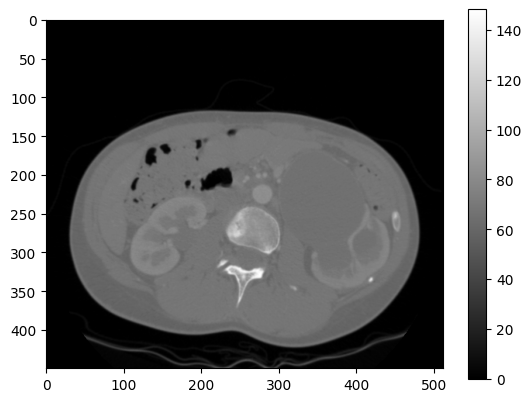

In [ ]:
plt.imshow(image[:, :, 190])

plt.colorbar()
plt.gray()

In [ ]:
opened = phantom_builder.morph_open(image, 5)


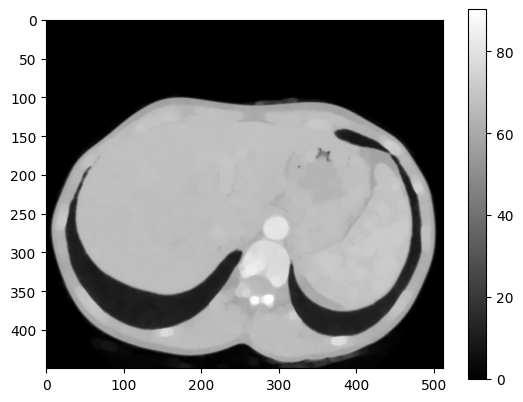

In [ ]:
plt.imshow(opened[:, :, 0])
plt.colorbar()
plt.gray()

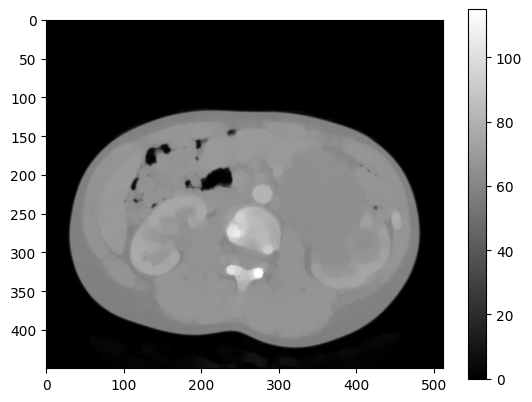

In [ ]:
plt.imshow(opened[:, :, 190])
plt.colorbar()
plt.gray()

In [ ]:
fg_mask = phantom_builder.make_fg_mask(opened, opened.shape[2], fg_threshold = 40)



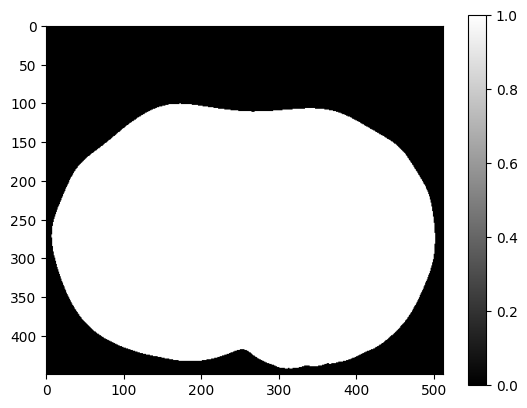

In [ ]:
plt.imshow(fg_mask[:, :, 0])
plt.colorbar()
plt.gray()

In [ ]:
vertices, triangles = phantom_builder.make_surface_mesh(fg_mask, voxel_size, './abdomen_smoothed.obj')


In [ ]:

surface_mesh = io.read_triangle_mesh("../demos/kidney_files/abdomen_smoothed_scaled.obj")


In [ ]:
body_mask = phantom_builder.voxelize("../demos/kidney_files/abdomen_smoothed_scaled.obj", voxel_size[0])


# cortex_mask = 
# medulla_mask = 

# fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=1)
# renal_cortex = tissue.Tissue(name='kidney_cortex', c=1571.3, rho=1049, sigma=15, scale=0.0001, label=2)
# renal_medulla = tissue.Tissue(name='kidney_medulla', c=1564, rho=1066, sigma=12, scale=0.0001, label=3)

# test_phantom.add_tissue(fat, mask=body_mask))
# test_phantom.add_tissue(renal_cortex, mask=cortex_mask)
# test_phantom.add_tissue(renal_medulla, mask=medulla_mask)

# surface_mesh = o3d.t.geometry.TriangleMesh.from_legacy(surface_mesh)
# surface_mesh.compute_vertex_normals()
# surface_mesh.compute_triangle_normals()

# vertices = surface_mesh.vertex.positions
# vertex_normals = surface_mesh.vertex.normals
# triangle_normals = surface_mesh.triangle.normals

# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 32, 
#                                     width = 20e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/3,
#                                     ray_num = 32, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 20e-3,
#                                     ) for i in range(1)]

# for t in transducers:
#     t.make_sensor_coords(test_phantom.baseline[0])

# test_set = transducer_set.TransducerSet(transducers, seed=8888)
# test_transducer_set.assign_pose(0, geometry.Transform(-theta*normals[vertex_num], vertices[vertex_num]))

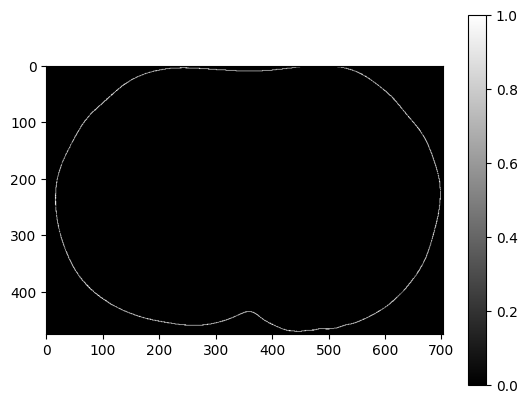

In [ ]:
plt.imshow(body_mask[:, :, 400])
plt.colorbar()
plt.gray()

In [ ]:
g_shape = [703, 448, 475] #body_mask.shape
max_bound = surface_mesh.get_max_bound()
min_bound = surface_mesh.get_min_bound()
print(max_bound)
print(min_bound)


[0.204208   0.38683501 0.148469  ]
[-0.209758  0.123022 -0.131181]


In [ ]:
capsule_mask = voxelize2("../demos/kidney_files/kidney_capsule.obj", voxel_size[0], min_bounds = min_bound, max_bounds = max_bound, grid_shape = g_shape )


[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.


In [ ]:
mask = capsule_mask + body_mask

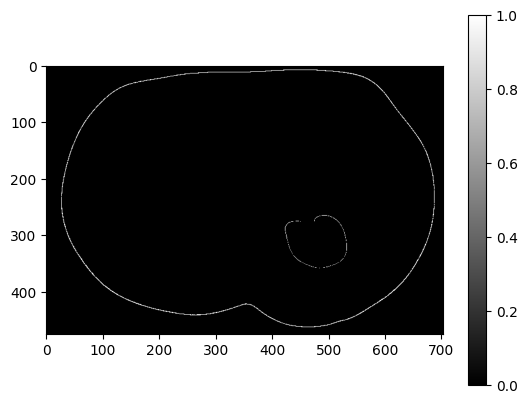

In [ ]:
plt.imshow(mask[:, :, 330])
plt.colorbar()
plt.gray()

[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.


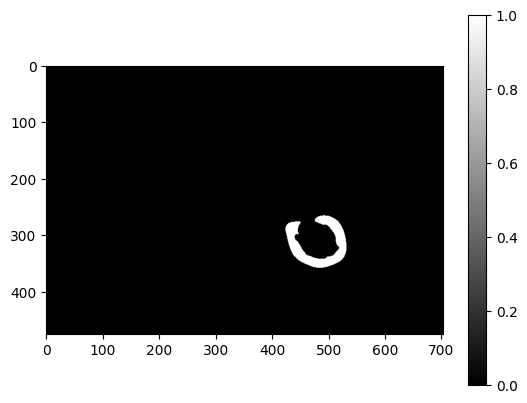

In [ ]:
cortex_mask = voxelize2("../demos/kidney_files/outer_cortex.obj", voxel_size[0], min_bounds = min_bound, max_bounds = max_bound, grid_shape = g_shape )
plt.imshow(cortex_mask[:, :, 330])
plt.colorbar()
plt.gray()

[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.


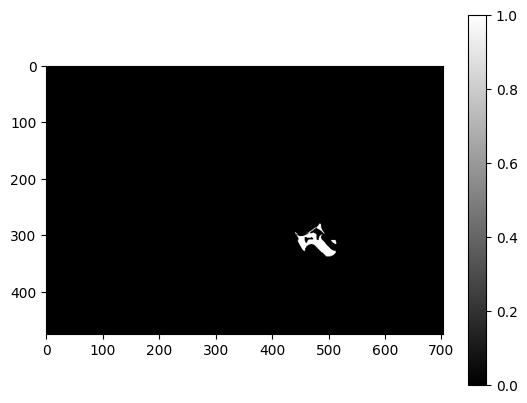

In [ ]:
column_mask = phantom_builder.voxelize("../demos/kidney_files/renal_column.obj", voxel_size[0], min_bounds = min_bound, max_bounds = max_bound, grid_shape = g_shape )
plt.imshow(column_mask[:, :, 330])
plt.colorbar()
plt.gray()

In [ ]:
blood_mask = phantom_builder.voxelize("../demos/kidney_files/renal_column.obj", voxel_size[0], min_bounds = min_bound, max_bounds = max_bound, grid_shape = g_shape,make_convex=True )
vertices, triangles = phantom_builder.make_surface_mesh(blood_mask, [voxel_size[0], voxel_size[0], voxel_size[0]], '../demos/kidney_files/kidney_blood.obj')




[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.


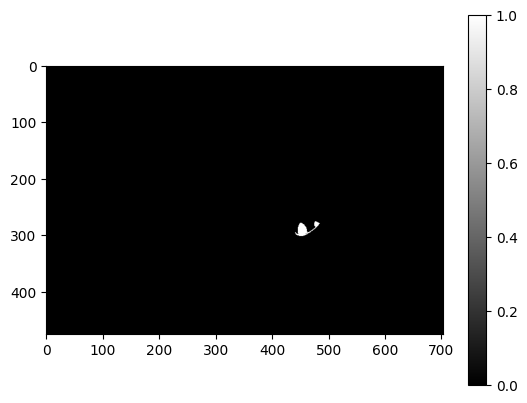

In [ ]:
hilum_mask = voxelize2("../demos/kidney_files/hilum.obj", voxel_size[0], min_bounds = min_bound, max_bounds = max_bound, grid_shape = g_shape )
plt.imshow(hilum_mask[:, :, 330])
plt.colorbar()
plt.gray()

[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.


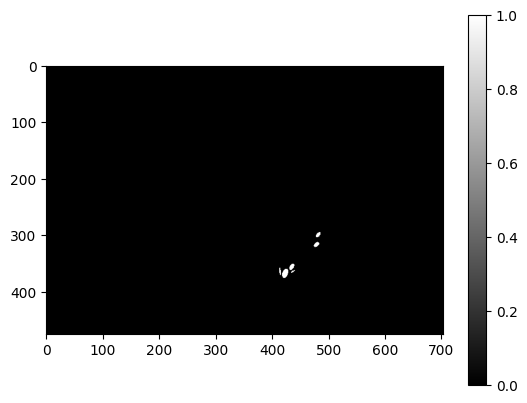

In [ ]:
papilla_mask = voxelize2("../demos/kidney_files/renal_papilla.obj", voxel_size[0], min_bounds = min_bound, max_bounds = max_bound, grid_shape = g_shape )
plt.imshow(papilla_mask[:, :, 300])
plt.colorbar()
plt.gray()

[Open3D WARNING] Legacy mesh has more than 1 material which is not supported by Tensor-based meshes.


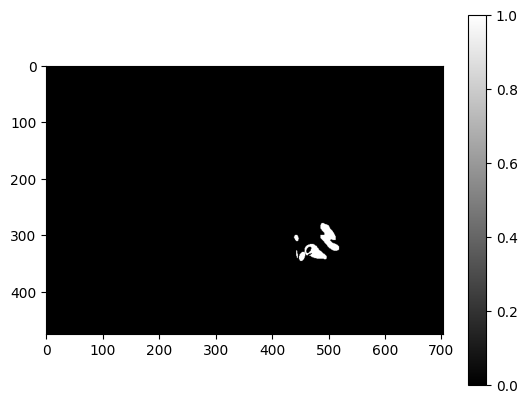

In [ ]:
pyramid_mask = voxelize2("../demos/kidney_files/renal_pyramids.obj", voxel_size[0], min_bounds = min_bound, max_bounds = max_bound, grid_shape = g_shape )
plt.imshow(pyramid_mask[:, :, 330])
plt.colorbar()
plt.gray()

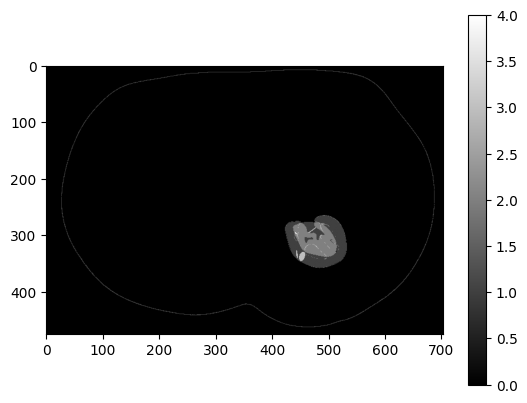

In [ ]:
full_mask = mask + cortex_mask + column_mask + papilla_mask + hilum_mask + pyramid_mask + blood_mask

plt.imshow(full_mask[:, :, 330])
plt.colorbar()
plt.gray()


In [ ]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = g_shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
medulla = tissue.Tissue(name='renal_medulla', c=1564, rho=1044, sigma=40, scale=0.0001, label=2)
cortex = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=5, scale=0.0001, label=3)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=4)
connective = tissue.Tissue(name='connective_tissue', c=1450, rho=1027, sigma=30, scale=0.0001, label=5)


test_phantom.add_tissue(fat, mask=np.ones(g_shape))
test_phantom.add_tissue(blood, mask=blood_mask)
test_phantom.add_tissue(connective, mask=capsule_mask)
test_phantom.add_tissue(cortex, mask=cortex_mask)
test_phantom.add_tissue(cortex, mask=column_mask)
test_phantom.add_tissue(blood, mask=hilum_mask)
test_phantom.add_tissue(medulla, mask=pyramid_mask)
test_phantom.add_tissue(medulla, mask=papilla_mask)

test_phantom.set_default_tissue('fat')

In [ ]:
target_pt = np.array([150*voxel_size[0], 350*voxel_size[1], 190*voxel_size[2]])
print(target_pt)

chi = 0.25
alpha = 0.5*1**1.5 / 8.686 * 100
radius = -np.log(chi)/(2*alpha) # in meters to match mesh coordinate system

print(radius)

[0.10224615 0.23857435 0.2375    ]
0.1204135282068737


In [ ]:
# begin snap-to-surface algo here

def snap_to_surface(point, surface):
    scene = o3d.t.geometry.RaycastingScene()
    _ = scene.add_triangles(surface)
    query_pt = o3d.core.Tensor([point], dtype=o3d.core.Dtype.Float32)
    closest_pt = scene.compute_closest_points(query_pt)
    closest_triangle = closest_pt['primitive_ids'][0].item()
    return closest_pt['points'].numpy(), closest_triangle

    return scene.compute_closest_points(query_pt), surface

closest_pt, closest_triangle = snap_to_surface([400*voxel_size[0]+min_bound[0], 600*voxel_size[0]+min_bound[1], 330*voxel_size[0]+min_bound[2]], surface_mesh)
print(closest_pt)





TypeError: add_triangles(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cpu.pybind.t.geometry.RaycastingScene, vertex_positions: open3d.cpu.pybind.core.Tensor, triangle_indices: open3d.cpu.pybind.core.Tensor) -> int
    2. (self: open3d.cpu.pybind.t.geometry.RaycastingScene, mesh: open3d.cpu.pybind.t.geometry.TriangleMesh) -> int

Invoked with: <open3d.cpu.pybind.t.geometry.RaycastingScene object at 0x2a7bfe370>, TriangleMesh with 3745872 points and 1293108 triangles.

In [ ]:
# begin inverse field of view code here 

#use boolean_intersection from o3d.t.geometry.TriangleMesh

sphere = o3d.t.geometry.TriangleMesh.from_legacy(o3d.geometry.TriangleMesh.create_sphere(radius).translate(target_pt))
cube = o3d.t.geometry.TriangleMesh.from_legacy(o3d.geometry.TriangleMesh.create_box(width=0.2, height = 0.1, depth = 0.1))
# int_scene = o3d.t.geometry.RacastingScene()
# ids = {}
# ids[int_scene.add_triangles(surface_mesh)] = 'body_surface'
# ids[int_scene.add_triangles(sphere)] = 'sphere'

# intersection = surface_mesh.boolean_intersection(sphere)

# visualization.draw([{'name': 'intersection', 'geometry': intersection}])

In [ ]:
#intersection = cube.boolean_intersection(sphere)


dir_path = '../demos/kidney_files'
file_list = [f for f in listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))] 
file_list = [f for f in file_list if os.path.splitext(f)[-1].lower() == ".obj"]
file_list.sort()
print(file_list)

new_file_list = [os.path.join(dir_path, f) for f in file_list]

print(new_file_list)

['0_kidney_blood.obj', '1_kidney_capsule.obj', '2_outer_cortex.obj', '3_renal_column.obj', '4_hilum.obj', '5_renal_pyramids.obj', '6_renal_papilla.obj']
['../demos/kidney_files/0_kidney_blood.obj', '../demos/kidney_files/1_kidney_capsule.obj', '../demos/kidney_files/2_outer_cortex.obj', '../demos/kidney_files/3_renal_column.obj', '../demos/kidney_files/4_hilum.obj', '../demos/kidney_files/5_renal_pyramids.obj', '../demos/kidney_files/6_renal_papilla.obj']
